$$ \LaTeX \text{ command declarations here.}
\newcommand{\R}{\mathbb{R}}
\renewcommand{\vec}[1]{\mathbf{#1}}
\newcommand{\X}{\mathcal{X}}
\newcommand{\D}{\mathcal{D}}
\newcommand{\G}{\mathcal{G}}
\newcommand{\Parents}{\mathrm{Parents}}
\newcommand{\NonDesc}{\mathrm{NonDesc}}
\newcommand{\I}{\mathcal{I}}
\newcommand{\dsep}{\text{d-sep}}
$$

In [1]:
from __future__ import division

# scientific
%matplotlib inline
from matplotlib import pyplot as plt;
import numpy as np;
import sklearn as skl;
import sklearn.datasets;
import sklearn.cluster;

# ipython
import IPython;

# python
import os;

#####################################################

# image processing
import PIL;

# trim and scale images
def trim(im, percent=100):
    print("trim:", percent);
    bg = PIL.Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = PIL.ImageChops.difference(im, bg)
    diff = PIL.ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        x = im.crop(bbox)
        return x.resize(((x.size[0]*percent)//100, (x.size[1]*percent)//100), PIL.Image.ANTIALIAS);


#####################################################

# daft (rendering PGMs)
import daft;

# set to FALSE to load PGMs from static images
RENDER_PGMS = False;

# decorator for pgm rendering
def pgm_render(pgm_func):
    def render_func(path, percent=100, render=None, *args, **kwargs):
        print("render_func:", percent);
        # render
        render = render if (render is not None) else RENDER_PGMS;
        
        if render:
            print("rendering");
            # render
            pgm = pgm_func(*args, **kwargs);
            pgm.render();
            pgm.figure.savefig(path, dpi=300);
            
            # trim
            img = trim(PIL.Image.open(path), percent);
            img.save(path, 'PNG');
        else:
            print("not rendering");
        
        # error
        if not os.path.isfile(path):
            raise "Error:  Graphical model image %s not found.  You may need to set RENDER_PGMS=True.";
        
        # display
        return IPython.display.Image(filename=path);#trim(PIL.Image.open(path), percent);
    
    return render_func;

######################################################

# EECS 545:  Machine Learning

## Lecture 15:  Latent Variables, d-Separation, K-Means

- Instructor:  **Jacob Abernethy**
- Date:  March 14, 2016

*Lecture Exposition:*  Saket & Ben

## References

- **[MLAPP]** Murphy, Kevin. [*Machine Learning:  A Probabilistic Perspective*](https://mitpress.mit.edu/books/machine-learning-0).  2012.
- **[PRML]** Bishop, Christopher.  [*Pattern Recognition and Machine Learning*](http://research.microsoft.com/en-us/um/people/cmbishop/prml/).  2006.
- **[Koller & Friedman 2009]** Koller, Daphne and Nir Friedman.  [*Probabilistic Graphical Models*](https://mitpress.mit.edu/books/probabilistic-graphical-models).  2009.

## Outline

- Probabilistic Graphical Models
    - Latent Variable Models
    - d-separation in Bayesian Networks
- Clustering & Mixture Models
    - K-Means Clustering

# Latent Variable Models

> Uses material from **[MLAPP]** §10.1-10.4, §11.1-11.2

### Latent Variable Models

In general, the goal of probabilistic modeling is to 
> Use what we know to make *inferences* about what we don't know.

Graphical models provide a natural framework for this problem.
- Assume unobserved variables are correlated due to the influence of unobserved **latent variables**.
- Latent variables encode beliefs about the generative process.

In a graphical model, we will often **shade in** the observed variables to distinguish them from hidden variables.

### Example:  Gaussian Mixture Models

This dataset is hard to explain with a single distribution.
- Underlying density is complicated overall...
- But it's clearly three Gaussians!

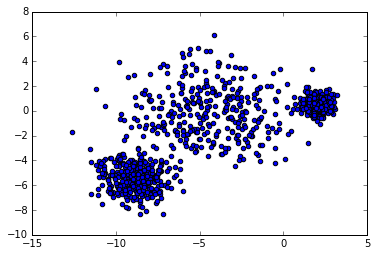

In [2]:
X, y = skl.datasets.make_blobs(1000, cluster_std=[1.0, 2.5, 0.5], random_state=170)
plt.scatter(X[:,0], X[:,1])

### Example:  Mixture Models

Instead, introduce a latent **cluster label** $z_j \in [K]$ for each datapoint $x_j$,
$$
\begin{align}
z_j &\sim \mathrm{Cat}(\pi_1, \dots, \pi_K) 
    & \forall\, j=1,\dots,N \\
x_j \mid z_j &\sim \mathcal{N}(\mu_{z_j}, \Sigma_{z_j})
    & \forall\, j=1,\dots,N \\
\end{align}
$$

This allows us to explain a complicated density as a **mixture** of simpler densities:
$$
P(x | \mu, \Sigma) = \sum_{k=1}^K \pi_k \mathcal{N}(x | \mu_k, \Sigma_k)
$$

### Example:  Mixture Models

In [3]:
@pgm_render
def pgm_gmm():
    pgm = daft.PGM([4,4], origin=[-2,-1], node_unit=0.8, grid_unit=2.0);
    # nodes
    pgm.add_node(daft.Node("pi", r"$\pi$", 0, 1));
    pgm.add_node(daft.Node("z", r"$Z_j$", 0.7, 1));
    pgm.add_node(daft.Node("x", r"$X_j$", 1.3, 1, observed=True));
    pgm.add_node(daft.Node("mu", r"$\mu$", 0.7, 0.3));
    pgm.add_node(daft.Node("sigma", r"$\Sigma$", 1.3, 0.3));
    
    # edges
    pgm.add_edge("pi", "z", head_length=0.08);
    pgm.add_edge("z", "x", head_length=0.08);
    pgm.add_edge("mu", "x", head_length=0.08);
    pgm.add_edge("sigma", "x", head_length=0.08);
    
    pgm.add_plate(daft.Plate([0.4,0.8,1.3,0.5], label=r"$\qquad\qquad\qquad\;\; N$",
    shift=-0.1))
    
    return pgm;

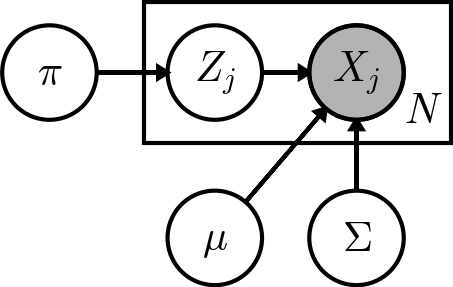

In [4]:
%%capture
pgm_gmm("images/pgm/pgm-gmm.png")

### Example:  Hidden Markov Models

Noisy observations $X_k$ generated from hidden Markov chain $Y_k$.
$$
P(\vec{X}, \vec{Y}) = P(Y_1) P(X_1 \mid Y_1) \prod_{k=2}^N \left(P(Y_k \mid Y_{k-1}) P(X_k \mid Y_k)\right)
$$

In [5]:
@pgm_render
def pgm_hmm():
    pgm = daft.PGM([7, 7], origin=[0, 0])

    # Nodes
    pgm.add_node(daft.Node("Y1", r"$Y_1$", 1, 3.5))
    pgm.add_node(daft.Node("Y2", r"$Y_2$", 2, 3.5))
    pgm.add_node(daft.Node("Y3", r"$\dots$", 3, 3.5, plot_params={'ec':'none'}))
    pgm.add_node(daft.Node("Y4", r"$Y_N$", 4, 3.5))

    pgm.add_node(daft.Node("x1", r"$X_1$", 1, 2.5, observed=True))
    pgm.add_node(daft.Node("x2", r"$X_2$", 2, 2.5, observed=True))
    pgm.add_node(daft.Node("x3", r"$\dots$", 3, 2.5, plot_params={'ec':'none'}))
    pgm.add_node(daft.Node("x4", r"$X_N$", 4, 2.5, observed=True))


    # Add in the edges.
    pgm.add_edge("Y1", "Y2", head_length=0.08)
    pgm.add_edge("Y2", "Y3", head_length=0.08)
    pgm.add_edge("Y3", "Y4", head_length=0.08)

    pgm.add_edge("Y1", "x1", head_length=0.08)
    pgm.add_edge("Y2", "x2", head_length=0.08)
    pgm.add_edge("Y4", "x4", head_length=0.08)
    
    return pgm;

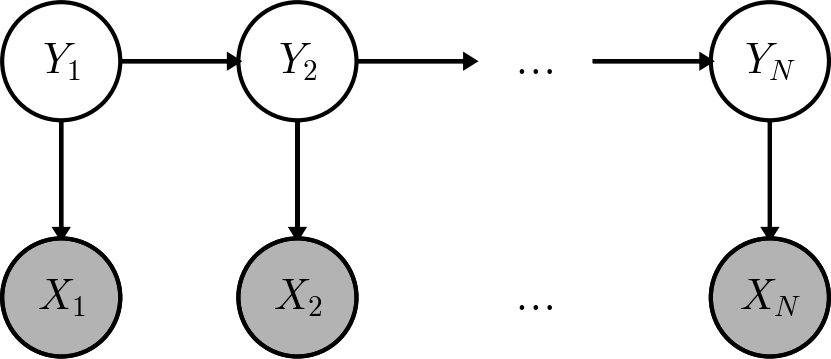

In [6]:
%%capture
pgm_hmm("images/pgm/hmm.png");

### Example:  Unsupervised Learning

Latent variables are fundamental to unsupervised and deep learning.
- Serve as a **bottleneck**
- Compute a **compressed** representation of data

In [7]:
@pgm_render
def pgm_unsupervised():
    pgm = daft.PGM([6, 6], origin=[0, 0])

    # Nodes
    pgm.add_node(daft.Node("d1", r"$Z_1$", 2, 3.5))
    pgm.add_node(daft.Node("di", r"$Z_2$", 3, 3.5))
    pgm.add_node(daft.Node("dn", r"$Z_3$", 4, 3.5))

    pgm.add_node(daft.Node("f1", r"$X_1$", 1, 2.50, observed=True))
    pgm.add_node(daft.Node("fi-1", r"$X_2$", 2, 2.5, observed=True))
    pgm.add_node(daft.Node("fi", r"$X_3$", 3, 2.5, observed=True))
    pgm.add_node(daft.Node("fi+1", r"$X_4$", 4, 2.5, observed=True))
    pgm.add_node(daft.Node("fm", r"$X_N$", 5, 2.5, observed=True))


    # Add in the edges.
    pgm.add_edge("d1", "f1", head_length=0.08)
    pgm.add_edge("d1", "fi-1", head_length=0.08)
    pgm.add_edge("d1", "fi", head_length=0.08)
    pgm.add_edge("d1", "fi+1", head_length=0.08)
    pgm.add_edge("d1", "fm", head_length=0.08)

    pgm.add_edge("di", "f1", head_length=0.08)
    pgm.add_edge("di", "fi-1", head_length=0.08)
    pgm.add_edge("di", "fi", head_length=0.08)
    pgm.add_edge("di", "fi+1", head_length=0.08)
    pgm.add_edge("di", "fm", head_length=0.08)

    pgm.add_edge("dn", "f1", head_length=0.08)
    pgm.add_edge("dn", "fi-1", head_length=0.08)
    pgm.add_edge("dn", "fi", head_length=0.08)
    pgm.add_edge("dn", "fi+1", head_length=0.08)
    pgm.add_edge("dn", "fm", head_length=0.08)
    
    return pgm

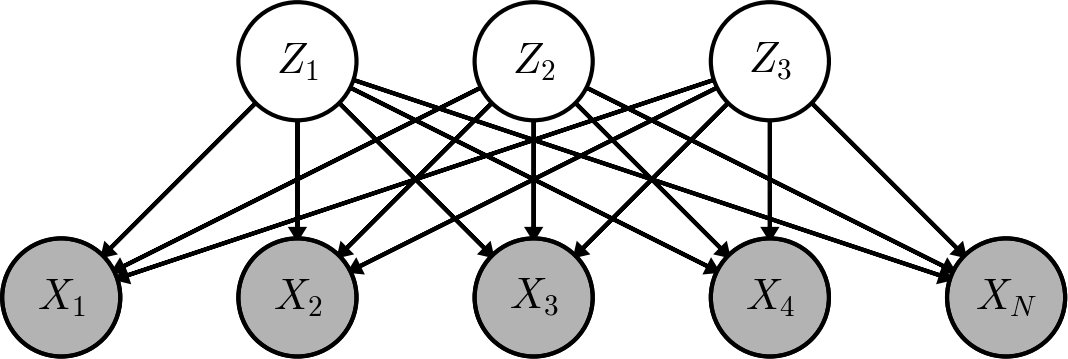

In [8]:
%%capture
pgm_unsupervised("images/pgm/unsupervised.png");

### Other Latent Variable Models

Many other models in machine learning involve latent variables:

- Neural Networks / Multilayer Perceptrons
- Restricted Boltzmann Machines
- Deep Belief Networks
- Probabilistic PCA

### Latent Variable Models:  Complexity

Latent variable models exhibit **emergent complexity**.
- Although each conditional distribution is simple,
- The joint distribution is capable of modeling complex interactions.

However, latent variables make learning difficult.
- Inference is challening in models with latent variables.
- They can introduce new dependencies between observed variables.

# Bayesian Networks
## Part II:  Inference, Learning, and d-Separation

> Uses material from **[Koller & Friedman 2009]** Chapter 3, **[MLAPP]** Chapter 10, and **[PRML]** §8.2.1

### Bayesian Networks:  Terminology

Typically, our models will have
- Observed variables $X$
- Hidden variables $Z$
- Parameters $\theta$

Occasionally, we will distinguish between **inference** and **learning**.

### Bayesian Networks:  Inference

**Inference**:  Estimate hidden variables $Z$ from observed variables $X$.
$$
P(Z | X,\theta) = \frac{P(X,Z | \theta)}{P(X|\theta)}
$$

- Denominator $P(X|\theta)$ is sometimes called the probability of the **evidence**.
- Occasionally we care only about a subset of the hidden variables, and marginalize out the rest.

### Bayesian Networks:  Learning

**Learning:** Estimate parameters $\theta$ from observed data $X$.
$$
P(\theta \mid X) = \sum_{z \in Z} P(\theta, z \mid X) = \sum_{z \in Z} P(\theta \mid z, X) P(z \mid X)
$$

To Bayesians, parameters *are* hidden variables, so inference and learning are equivalent.

### Bayesian Networks:  Probability Queries

In general, it is useful to compute $P(A|B)$ for arbitrary collections $A$ and $B$ of variables.
- Both inference and learning take this form.

To accomplish this, we must understand the **independence structure** of any given graphical model.

### Review:  Local Independencies

Every Bayesian Network $\G$ encodes a set $\I_\ell(\G)$ of **local independence assumptions**:

> For each variable $X_k$, we have $(X_k \perp \NonDesc_\G(X_k) \mid \Parents_\G(X_k))$

Every node $X_k$ is conditionally independent of its nondescendants given its parents.

> For arbitrary sets of variables, when does $(A \perp B \mid C)$ hold?

### Review:  I-Maps

If $P$ satisfies the independence assertions made by $\G$, we say that
- $\G$ is an **I-Map** for $P$
- or that $P$ **satisfies** $\G$.

Any distribution satisfying $\G$ shares common structure.
- We will exploit this structure in our algorithms
- This is what makes graphical models so **powerful**!

### Review:  Factorization Theorem

Last time, we proved that for any $P$ satisfying $\G$,
$$
P(X_1, \dots, X_N) = \prod_{k=1}^N P(X_k \mid \Parents_\G(X_k))
$$

If we understand independence structure, we can factorize arbitrary conditional distributions:
$$
P(A_1, \dots, A_n \mid B_1, \dots, B_m) = \;?
$$

###  Question 1:  Is $(A \perp B)$?

In [9]:
@pgm_render
def pgm_question1():
    pgm = daft.PGM([4, 4], origin=[0, 0])

    # Nodes
    pgm.add_node(daft.Node("c", r"$C$", 2, 3.5))
    pgm.add_node(daft.Node("a", r"$A$", 1.3, 2.5))
    pgm.add_node(daft.Node("b", r"$B$", 2.7, 2.5))

    # Add in the edges.
    pgm.add_edge("c", "a", head_length=0.08)
    pgm.add_edge("c", "b", head_length=0.08)

    return pgm;

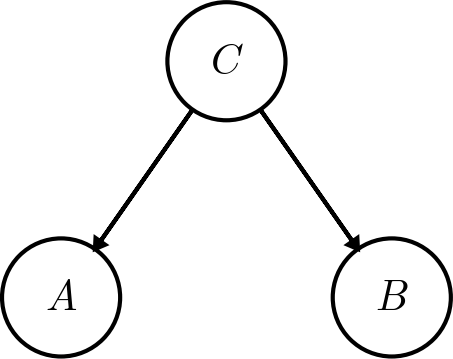

In [10]:
%%capture
pgm_question1("images/pgm/question1.png")

### Answer 1:  No!

No!  $A$ and $B$ are not marginally independent.
- Note $C$ is not shaded, so we don't observe it.

In general, 

$$
P(A,B) = \sum_{c \in C} P(A,B,c) = \sum_{c \in C} P(A|C)P(B|C)P(C) \neq P(A)P(B)
$$

### Question 2:  Is $(A \perp B \mid C)$?

In [11]:
@pgm_render
def pgm_question2():
    pgm = daft.PGM([4, 4], origin=[0, 0])

    # Nodes
    pgm.add_node(daft.Node("c", r"$C$", 2, 3.5, 
                           observed=True))
    pgm.add_node(daft.Node("a", r"$A$", 1.3, 2.5))
    pgm.add_node(daft.Node("b", r"$B$", 2.7, 2.5))

    # Add in the edges.
    pgm.add_edge("c", "a", head_length=0.08)
    pgm.add_edge("c", "b", head_length=0.08)
    
    return pgm

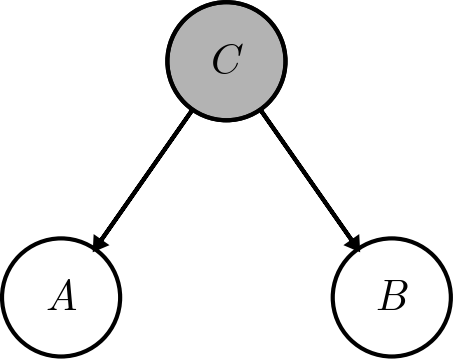

In [12]:
%%capture
pgm_question2("images/pgm/question2.png")

### Answer 2:  Yes!

Yes!  $(A \perp B | C)$ follows from the local independence properties of Bayesian networks.

> Every variable is conditionally independent of its nondescendants given its parents.

Observing $C$ *blocks* the path of influence from $A$ to $B$. Or, using factorization theorem:
$$
\begin{align}
P(A,B|C) & = \frac{P(A,B,C)}{P(C)}  \\
& = \frac{P(C)P(A|C)P(B|C)}{P(C)} \\
& = P(A|C)P(B|C)
\end{align}
$$

### Question 3:  Is $(A \perp B)$?

In [13]:
@pgm_render
def pgm_question3():
    pgm = daft.PGM([4, 4], origin=[0, 0])

    # Nodes
    pgm.add_node(daft.Node("c", r"$C$", 2, 3.5))
    pgm.add_node(daft.Node("a", r"$A$", 1.3, 2.5))
    pgm.add_node(daft.Node("b", r"$B$", 2.7, 2.5))

    # Add in the edges.
    pgm.add_edge("a", "c", head_length=0.08)
    pgm.add_edge("c", "b", head_length=0.08)
    
    return pgm

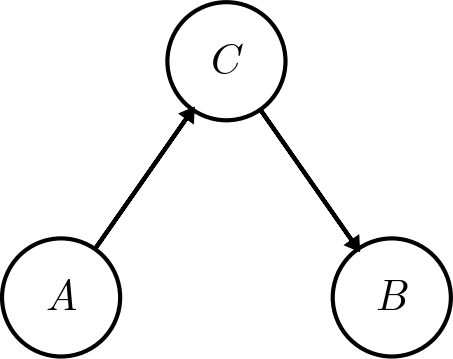

In [14]:
%%capture
pgm_question3("images/pgm/question3.png")

### Answer 3:  No!

Again, $C$ is not given, so $A$ and $B$ are dependent.



### Question 4:  Is $(A \perp B \mid C)$?

In [15]:
@pgm_render
def pgm_question4():
    pgm = daft.PGM([4, 4], origin=[0, 0])

    # Nodes
    pgm.add_node(daft.Node("c", r"$C$", 2, 3.5, observed=True))
    pgm.add_node(daft.Node("a", r"$A$", 1.3, 2.5))
    pgm.add_node(daft.Node("b", r"$B$", 2.7, 2.5))

    # Add in the edges.
    pgm.add_edge("a", "c", head_length=0.08)
    pgm.add_edge("c", "b", head_length=0.08)
    
    return pgm

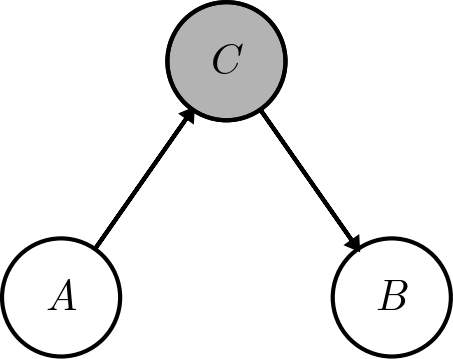

In [16]:
%%capture
pgm_question4("images/pgm/question4.png")

### Answer 4:  Yes!

Again, observing $C$ *blocks* influence from $A$ to $B$.

> Every variable is conditionally independent of its nondescendants given its parents.

### Question 5:  Is $(A \perp B)$?

In [17]:
@pgm_render
def pgm_question5():
    pgm = daft.PGM([4, 4], origin=[0, 0])

    # Nodes
    pgm.add_node(daft.Node("c", r"$C$", 2, 3.5))
    pgm.add_node(daft.Node("a", r"$A$", 1.3, 2.5))
    pgm.add_node(daft.Node("b", r"$B$", 2.7, 2.5))

    # Add in the edges.
    pgm.add_edge("a", "c", head_length=0.08)
    pgm.add_edge("b", "c", head_length=0.08)
    
    return pgm

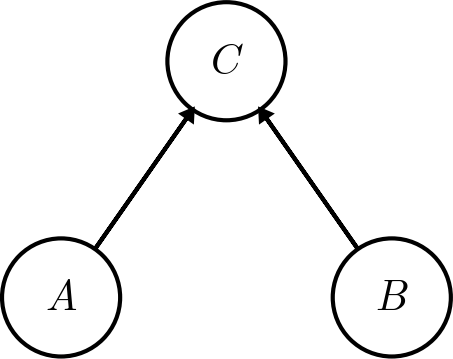

In [18]:
%%capture
pgm_question5("images/pgm/question5.png")

### Answer 5:  Yes!

Using the factorization rule,
$$
P(A,B,C) = P(A)P(B)P(C\mid A,B)
$$
Therefore, marginalizing out $C$,
$$
\begin{align}
P(A,B) & = \sum_{c \in C} P(A,B,c)  \\
& = \sum_{c \in C} P(A)P(B) P(c \mid A,B) \\
& = P(A)P(B) \sum_{c \in C} P(c \mid A,B) = P(A)P(B)
\end{align}
$$

### Question 6:  Is $P(A \perp B \mid C)$?

In [19]:
@pgm_render
def pgm_question6():
    pgm = daft.PGM([4, 4], origin=[0, 0])

    # Nodes
    pgm.add_node(daft.Node("c", r"$C$", 2, 3.5, observed=True))
    pgm.add_node(daft.Node("a", r"$A$", 1.3, 2.5))
    pgm.add_node(daft.Node("b", r"$B$", 2.7, 2.5))

    # Add in the edges.
    pgm.add_edge("a", "c", head_length=0.08)
    pgm.add_edge("b", "c", head_length=0.08)
    
    return pgm

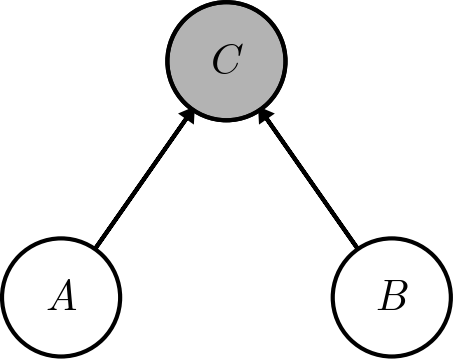

In [20]:
%%capture
pgm_question6("images/pgm/question6.png")

### Answer:  No!

$A$ can influence $B$ via $C$.  
$$
P(A,B | C) = \frac{P(A,B,C)}{P(C)} = \frac{P(A)P(B)P(C|A,B)}{P(C)}
$$

This does not factorize in general to $P(A|C)P(B|C)$.

### Example:  Battery, Fuel, and Gauge

Consider three binary random variables
- Battery $B$ is either charged $(B=1)$ or dead, $(B=0)$
- Fuel tank $F$ is either full $(F=1)$ or empty, $(F=0)$
- Fuel gauge $G$ either indicates full $(G=1)$ or empty, $(G=0)$

Assume $(B \perp F)$ with priors
- $P(B = 1) = 0.9$
- $P(F = 1) = 0.9$

### Example:  Battery, Fuel, and Gauge

Given the state of the fuel tank and the battery, the fuel gauge reads full with probabilities: 
 - $p(G = 1 \mid B = 1, F = 1) = 0.8$
 - $p(G = 1 \mid B = 1, F = 0) = 0.2$
 - $p(G = 1 \mid B = 0, F = 1) = 0.2$
 - $p(G = 1 \mid B = 0, F = 0) = 0.1$

### Example:  Battery, Fuel, and Gauge

Without any observations, the probability of an empty fuel tank is
$$
P(F=0) = 1 - P(F = 1) = 0.1
$$

In [21]:
@pgm_render
def pgm_bfg_1():
    pgm = daft.PGM([4, 4], origin=[0, 0])

    # Nodes
    pgm.add_node(daft.Node("G", r"$G$", 2, 3.5))
    pgm.add_node(daft.Node("B", r"$B$", 1.3, 2.5))
    pgm.add_node(daft.Node("F", r"$F$", 2.7, 2.5))

    # Add in the edges.
    pgm.add_edge("B", "G", head_length=0.08)
    pgm.add_edge("F", "G", head_length=0.08)
    
    return pgm;

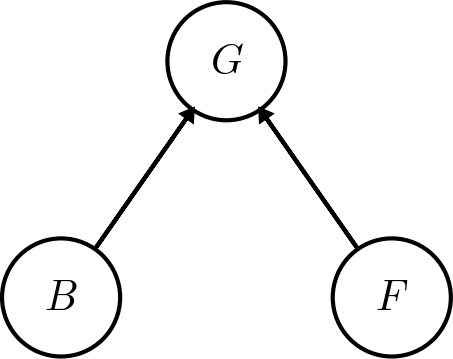

In [22]:
%%capture
pgm_bfg_1("images/pgm/bfg-1.png")

### Example:  Empty Gauge

Now, suppose the gauge reads $G=0$.  We have
$$
P(G=0) = \sum \limits_{B \in \{0, 1\}} \sum \limits_{F \in \{0, 1\}} 
 P(G = 0 \mid B, F) P(B) P(F) = 0.315
$$

> Verify this!

### Example:  Emtpy Gauge

In [23]:
@pgm_render
def pgm_bfg_2():
    pgm = daft.PGM([4, 4], origin=[0, 0])

    # Nodes
    pgm.add_node(daft.Node("G", r"$G$", 2, 3.5, offset=(0, 20), observed=True))
    pgm.add_node(daft.Node("B", r"$B$", 1.3, 2.5, offset=(0, 20)))
    pgm.add_node(daft.Node("F", r"$F$", 2.7, 2.5, offset=(0, 20)))

    # Add in the edges.
    pgm.add_edge("B", "G", head_length=0.08)
    pgm.add_edge("F", "G", head_length=0.08)
    
    return pgm;

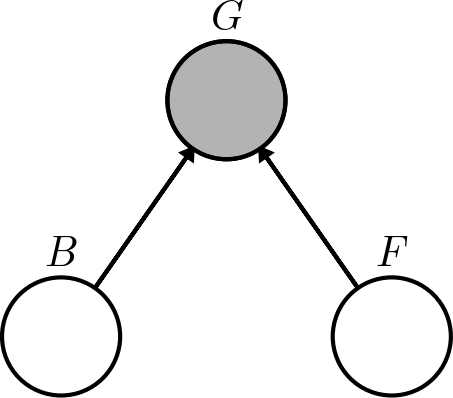

In [24]:
%%capture
pgm_bfg_2("images/pgm/bfg-2.png");

### Example:  Empty Gauge

Now, we also have 
$$
p(G = 0 \mid F = 0)
= \sum \limits_{B \in \{0, 1\}} p(G = 0 \mid B, F = 0) p(B) = 0.81
$$ 

Applying Bayes' Rule,
$$
\begin{align}
p(F = 0 \mid G = 0) 
&= \frac{p(G = 0 \mid F = 0) p(F = 0)}{p(G = 0)} \\
&\approx 0.257 > p(F = 0) = 0.10
\end{align}
$$

Observing an empty gauge makes it more likely that the tank is empty!

### Example:  Emtpy Gauge, Dead Battery

Now, suppose we *also* observe a dead battery $B =0$.  Then,
$$
\begin{align}
p(F = 0 \mid G = 0, B = 0) 
&= \frac{p(G = 0 \mid B = 0, F = 0) p(F = 0)}{\sum_{F \in \{0, 1\}} p(G = 0 \mid B = 0, F) p(F)} \\
&\approx 0.111
\end{align}
$$

### Example:  Emtpy Gauge, Dead Battery

In [25]:
@pgm_render
def pgm_bfg_3():
    pgm = daft.PGM([4, 4], origin=[0, 0])

    # Nodes
    pgm.add_node(daft.Node("G", r"$G$", 2, 3.5, offset=(0, 20), observed=True))
    pgm.add_node(daft.Node("B", r"$B$", 1.3, 2.5, offset=(0, 20), observed=True))
    pgm.add_node(daft.Node("F", r"$F$", 2.7, 2.5, offset=(0, 20)))

    # Add in the edges.
    pgm.add_edge("B", "G", head_length=0.08)
    pgm.add_edge("F", "G", head_length=0.08)
    
    return pgm;

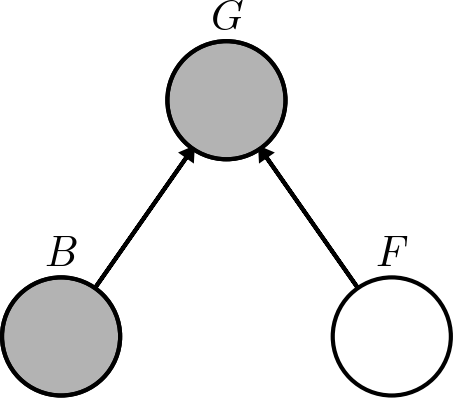

In [26]:
%%capture
pgm_bfg_3("images/pgm/bfg-3.png")

### Example:  Empty Gauge, Dead Battery

This is the **explaining away** phenomenon.
- The probability of an empty tank has decreased from $0.257$ to $0.111$ after observing the dead battery!
- A dead battery *explans* why the guage indicates an empty tank, reducing the probability that the tank is *really* empty.

Conditioning on a common child makes its parents dependent.

## Break time
<img src="images/boxing_cat.gif"/>

* Will extend deadline for project proposals by a few days.


### Bayesian Networks:  d-Separation

We say a trail $X \leftrightharpoons Z \leftrightharpoons Y$ is **active** when influence can flow from $X$ to $Y$ via $Z$.
- **Causal Trail:** $X \rightarrow Z \rightarrow Y$ is active iff $Z$ is hidden.
- **Evidential Trail:** $X \leftarrow Z \leftarrow Y$ is active iff $Z$ is hidden.
- **Common Cause:** $X \leftarrow Z \rightarrow Y$ is active iff $Z$ is hidden.
- **Common Effect:** $X \rightarrow Z \leftarrow Y$ is active iff $Z$ or a descendant of $Z$ is observed.

### Bayesian Networks:  d-Separation

A longer trail $X_1 \leftrightharpoons X_2 \leftrightharpoons \cdots \leftrightharpoons X_n$ is **active** if influence can flow from $X_1$ to $X_n$ along the trail.

- Requires that every $X_{k-1} \leftrightharpoons X_k \leftrightharpoons X_{k+1}$ is active.

In general, $X_1 \leftrightharpoons X_2 \leftrightharpoons \cdots \leftrightharpoons X_n$ is **active** given observed variables $Y$ if
- Whenever we have a v-structure $X_{k-1} \rightarrow X_k \leftarrow X_{k+1}$ then $X_k$ or one of its descendants is in $Y$.
- No other node along the trail is in $Y$.

### Bayesian Networks: d-Separation

Some graphs may have more than one trail between two given nodes.
- One node may inflence another if there exists an active trail between them.

Let $\mathbf{X}$, $\mathbf{Y}$, and $\mathbf{Z}$ be sets of nodes in $\G$.  We say $\mathbf{X}$ and $\mathbf{Y}$ are **d-separated** given $\mathbf{Z}$, denoted $\dsep_\G( \mathbf{X};\mathbf{Y} \mid \mathbf{Z})$ if there is no active trail between any nodes $X \in \mathbf{X}$ and $Y \in \mathbf{Y}$ given $\mathbf{Z}$.

### Bayesian Networks:  d-Separation

**Theorem:** (Koller & Friedman 3.5) For almost all distributions $P$ that factorize over $\G$, we have
$$
\dsep_\G(X; Y \mid Z) \iff (X \perp Y \mid Z)
$$

That is, except on a set of measure zero in the space of distributions, the concept of d-separation in $\G$ exactly captures the concept of conditional independence.
- To check if variables are independent, check for d-separation.

## Challenging quiz question:

<img src="images/piazza_question.png" width=600px/>

* Notice that there is an active path from $B$ to $E$:
$$B \to \boxed{D} \leftarrow A \to C \to E$$ 

# Clustering & K-Means

> Uses material from **[PRML]** §9.1

### Clustering:  Introduction

**Goal:** Partition data $\X = \{ x_1, \dots, x_n \} \subset \R^d$ into $K$ disjoint **clusters**.
- Points within a cluster should be more similar to each other than to points in other clusters.
- Estimate **cluster centers** $\mu_k \in \R^d$ for $k=1,\dots,K$
- Estimate **cluster assignments** $z_j \in \{1,\dots,K\}$ for each point $x_j$

Usually, we fix $K$ beforehand!  Use model selection to overcome this limitation.

### K-Means Clustering

The **K-Means** algorithm takes a simple, non-probabilistic approach.
- First, pick random cluster centers $\mu_k$.

Then, repeat until convergence:

<div style="margin:10px; padding: 10px; border: 2px solid black">
**E-Step:** Assign $x_j$ to the nearest cluster center $\mu_k$,
$$
z_j = \arg\min_k || x_j - \mu_k ||^2
$$

**M-Step:** Re-estimate cluster centers by averaging over assignments:
$$
\mu_k = \frac{1}{ \# \{ j \mid z_j =k \}} \sum_{j=1}^N x_j \mathbb{I}(z_j = k)
$$
</div>

### K-Means Clustering: Initialization

> Images taken from Bishop, **[PRML]**

<img src="images/kmeans-1.png">

### K-Means Clustering: E-Step

<img src="images/kmeans-2.png">

### K-Means Clustering: M-Step

<img src="images/kmeans-3.png">

### K-Means Clustering: E-Step

<img src="images/kmeans-4.png">

### K-Means Clustering: M-Step

<img src="images/kmeans-5.png">

### K-Means Clustering: E-Step

<img src="images/kmeans-6.png">

### K-Means Clustering: M-Step

<img src="images/kmeans-7.png">

### K-Means Clustering: E-Step

<img src="images/kmeans-8.png">

### K-Means Clustering: M-Step

<img src="images/kmeans-9.png">

### K-Means:  Cluster Geometry

Clusters are convex *nearest-neighbor* regions or **Vornoi Cells**.
- Piecewise-linear boundaries

K-means will fail to identify non-convex clusters.
- However, **kernelized K-means** is possible!

<img src="images/voronoi.jpg">

### K-Means Clustering:  Analysis

*Exercise:* Show that the K-Means algorithm finds a local minimum of the **distortion measure**, given by
$$
J(\mu_1, \ldots, \mu_k; z_1, \ldots, z_N) = \sum_{j=1}^N \sum_{k=1}^K \mathbb{I}(z_j=k) || x_j - \mu_k ||^2
$$

### K-Means:  Variants

K-Means is simple and easy to extend:

- **K-Means++:** Intelligently pick initial cluster centers
- **K-Means--:** Handle outliers
- **Nonparametric K-Means:** Automatically select number of clusters
- **Kernelized K-Means:** Non-convex clusters

Next lecture, we will cover **probabilistic clustering** through the use of mixture models.

### Variant:  [K-Means++](http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf)

Instead of initializing cluster centers randomly,

<div style="margin:10px; padding: 10px; border: 2px solid black">
<ol>
<li> Choose the first cluster center to be a random datapoint.
<li>Repeat until $K$ cluster centers have been selected:
    <ol>
    <li>For each datapoint $x_j$, compute distance $D(x_j)$ to nearest cluster.
    <li>Choose data point $x_j$ at random to be the new cluster center, with probability proportional to $D(x_j)^2$.
    </ol>
<li> Run K-means as usual. 
</ol>
</div>

### Variant:  [K-Means--](http://pmg.it.usyd.edu.au/outliers.pdf)

Vanilla K-Means is sensitive to outliers.  Instead, assume there are $\ell$ outliers, then

<div style="margin:10px; padding: 10px; border: 2px solid black">
<ol>
<li> Choose initial cluster centers as usual.
<li> For $k=1,2,\dots$:
    <ol>
    <li> For each datapoint $x_j$, compute distance $D(x_j)$ to nearest cluster.
    <li> Set $L_k$ to be the $\ell$ datapoints farthest from any cluster.
    <li> Perform the E and M steps as usual on $X \setminus L_k$.
    </ol>
<li> Return most recent outlier estimate $L_k$ in addition to usual cluster data.
</ol>
</div>

### Variant: [Nonparametric K-Means](http://www.cs.berkeley.edu/~jordan/papers/kulis-jordan-icml12.pdf)

Automatically add new clusters via a **maximum cluster radius** $\lambda$.

<div style="margin:10px; padding: 10px; border: 2px solid black">
<ol>
<li> Init $K=1$ and set $\mu_1$ to be the mean over datapoints.
<li> Repeat until convergence:
    <ol>
    <li> For each point $x_j$,
        <ol>
        <li> Compute distance $D(x_j)$ to nearest cluster.
        <li> If $D(x_j) > \lambda$, increment $K$ and create a new cluster centered at $x_j$.
        <li> Otherwise, assign $x_j$ to a cluster as usual.
        </ol>
    <li> Re-estimate cluster centers as usual.
    </ol>
</ol>
</div>